In [34]:
# Mogą byc błedy, kod pisany z palca

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import re
import os
import tensorflow as tf 

%load_ext autoreload
%autoreload 2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
import ipywidgets as widgets
from ipywidgets import interact
import pickle

## Dataset

In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
num_classes = 10
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [18]:
from collections import Counter
import matplotlib.mlab as mlab

matplotlib.rcParams.update({'font.size': 20})

def compute_statistics(y_pred):
    x_c = np.array(list(map(lambda t: (t[1], t[0]), zip(*np.histogram(y_pred, 70, normed=True)))))    
    mu = y_pred.mean()
    sigma = y_pred.std()
    x = np.linspace(-3, 3, 100)    
    gauss = mlab.normpdf(x, mu, sigma)    
    return {"hist": x_c, "gauss": [x, gauss]}


def plot_stats(lo_stat_data, la_stat_data): 
    
    x_c = lo_stat_data["hist"]    
    plt.plot(x_c[:, 0], x_c[:, 1], '-', lw=2,  label="hist (before activation)")
    plt.ylim([0, 1.2*np.max(x_c[:, 1])])
    x_c = la_stat_data["hist"]    
    plt.plot(x_c[:, 0], x_c[:, 1], 'r--', lw=1, label="hist (after activation)")
    plt.legend(loc=1)


def append_history(fc_pred_history, fc_pred):
    for i in range(len(fc_pred)):
        stat_data = compute_statistics(fc_pred[i])
        fc_pred_history[i].append(stat_data)    

def get_history_at(fc_pred_history, batch):
    stats = []
    for i in range(len(fc_pred_history)):
        stats.append(fc_pred_history[i][batch])
    return stats

def plot_history_at(fc_pred_history, batch):
    stat_data = get_history_at(fc_pred_history, batch)
    num_plots = len(stat_data)//2
    plt.figure(figsize=(15, 15))
    for i in range(num_plots):
        plt.subplot(2, num_plots//2, i + 1)
        plt.title(f"fc{i+1}")
        plot_stats(stat_data[i], stat_data[num_plots + i])
    plt.show()
    
def plot_interactive(fc_pred_history):
    def draw(batch):
        plot_history_at(fc_pred_history, batch)
        plt.show()

    n = len(fc_pred_history[0]) - 1
    interact(draw, batch=widgets.IntSlider(min=0, max=n, step=1, value=n))
    
def plot_loss_history(loss_history_tuple):
    def running_mean(x, N=100):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / N 
            
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.title("loss")
    
    params, loss_history = loss_history_tuple    
    plt.plot(running_mean(np.array(loss_history)[:, 0]), label=params['name'])
    
    plt.subplot(122)
    plt.title("acc")
    
    params, loss_history = loss_history_tuple
    plt.plot(running_mean(np.array(loss_history)[:, 1]), label=params['name'])
    
    plt.legend()
    plt.show()   

from keras.models import Model
from keras.layers import Dense, Convolution2D


def svd_orthonormal(shape):
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    # flat_shape = (shape[0], np.prod(shape[1:]))
    flat_shape = (np.prod(shape[:-1]), shape[-1])
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q


def get_activations(model, layer, batch_generator, steps):
    intermediate_layer_model = Model(inputs=model.get_input_at(0), outputs=layer.get_output_at(0))
    activations = intermediate_layer_model.predict_generator(batch_generator, steps=steps)
    return activations


def LSUVinit(model, batch_generator, steps, selu_init=False):
    # only these layer classes considered for 
    # LSUV initialization; add more if needed
    classes_to_consider = (Dense, Convolution2D)

    margin = 0.01
    max_iter = 10
    layers_inintialized = 0
    for layer in model.layers:
        print(layer.name)
        if not any([type(layer) is class_name for class_name in classes_to_consider]):
            continue
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(layer.get_output_shape_at(0)[1:]) < 32:
            print(layer.name, 'too small')
            continue
        print('LSUV initializing', layer.name)
        layers_inintialized += 1
        w_all = layer.get_weights()
        weights = np.array(w_all[0])
        weights = svd_orthonormal(weights.shape)
        biases = np.array(w_all[1])
        w_all_new = [weights, biases]
        layer.set_weights(w_all_new)
        acts1 = get_activations(model, layer, batch_generator, steps)
        var1 = np.var(acts1)
        iter1 = 0
        needed_variance = 1.0
        print(var1)

        while abs(needed_variance - var1) > margin:
            w_all = layer.get_weights()
            weights = np.array(w_all[0])
            biases = np.array(w_all[1])
            if np.abs(np.sqrt(var1)) < 1e-7:
                break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            w_all_new = [weights, biases]
            layer.set_weights(w_all_new)
            acts1 = get_activations(model, layer, batch_generator, steps)
            var1 = np.var(acts1)
            iter1 += 1
            print(var1)
            if iter1 > max_iter:
                break
                
        if type(layer) == Dense and selu_init:
            # Normalize Dense layer to have w=0 and tau=1
            w_all = layer.get_weights()
            weights = np.array(w_all[0])
            weights = weights - weights.mean(0)
            weights = weights/np.sqrt((weights**2).sum(0))

            biases = np.array(w_all[1])*0
            w_all_new = [weights, biases]
            layer.set_weights(w_all_new)
            print(weights.shape)
            print("w:", (weights).sum(0))
            print("tau:", (weights**2).sum(0))                
    print('LSUV: total layers initialized', layers_inintialized)
    return model


import keras.backend as K

def selu(x):
    """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
    # Arguments
        x: A tensor or variable to compute the activation function for.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * K.elu(x, alpha)


def prelu(name):
    prelu = keras.layers.advanced_activations.PReLU(alpha_initializer='zeros', name=name)
    return prelu

In [4]:
from os.path import join
batch_size = 64
num_classes = 10
num_batches = 50000
dataset_name = "cifar10"
model_type = "conv"
save_folder = "activations_history_data"

# Model

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.initializers import RandomNormal
from keras.regularizers import Regularizer
import keras.backend as K

from keras.regularizers import Regularizer
import keras.backend as K


class SeluConvRegularizer(Regularizer):

    def __init__(self, num_filters, mu=0.001, tau=0.001):
        self.mu = K.cast_to_floatx(mu)
        self.tau = K.cast_to_floatx(tau)
        self.num_filters = num_filters

    def __call__(self, x):
        x = K.reshape(x, shape=[-1, self.num_filters])
        mean_loss = self.mu * K.mean(K.square(K.sum(x, axis=0)))
        tau_loss = - self.tau * K.mean(K.log(K.sum(K.square(x), axis=0) + K.epsilon()))
        
        return mean_loss + tau_loss

    def get_config(self):
        return {'mu': float(self.mu),
                'tau': float(self.tau)}

    
class OrthoConvRegularizer(Regularizer):

    def __init__(self, num_filters, mu=0.01):
        self.mu = K.cast_to_floatx(mu)
        self.num_filters = num_filters

    def __call__(self, x):
        x = K.reshape(x, shape=[-1, self.num_filters])
        ortho_loss = self.mu * K.mean(K.square(K.dot(K.transpose(x), x) - K.eye(self.num_filters)))
        return ortho_loss

    def get_config(self):
        return {'mu': float(self.mu)}

    
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine import InputSpec
from keras.engine import Layer

from keras.layers.convolutional import _Conv
    
class LetsConv2D(_Conv):       
    def __init__(self, filters,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(LetsConv2D, self).__init__(
            rank=2,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.input_spec = InputSpec(ndim=4)

    def call(self, inputs):        
        
        outputs = K.conv2d(
            inputs,
            self.kernel,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
     
        
        if self.activation is not None:
            outputs = self.activation(outputs)
        
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        
        return outputs

In [7]:
def get_model(**params):
    
    activation = params.get("activation", 'linear')
    advanced_activation = params.get("advanced_activation", None)
    batch_norm = params.get("batch_norm", False)
    
    selu_init = params.get("selu_init", False)
    selu_reg = params.get("selu_reg", False)
    ortho_reg = params.get("ortho_reg", False)
    if ortho_reg:
        selu_reg = False
    
    num_layers = 4
    n_hidden = 32
    
    lets_conv = params.get("lets_conv", False)
    
    if not lets_conv:
        print("with Conv2D")
        conv_layer = Conv2D
    else:
        print("with LetsConv2D")
        conv_layer = LetsConv2D    
    
    def get_init():
        if selu_init:            
            init_scale = 1
            init = RandomNormal(stddev=np.sqrt(init_scale/n_hidden))
            return init
        else:
            return 'glorot_uniform'
       
    def get_reg(num_filters):
        if selu_reg:
            print("with selu Reg")
            return SeluConvRegularizer(num_filters)
        elif ortho_reg:
            print("with ortho Reg")
            return OrthoConvRegularizer(num_filters)
        else:
            return None
    
    model = Sequential()    
    model.add(conv_layer(32, (3, 3), 
                     padding='same',
                     input_shape=x_train.shape[1:], 
                     kernel_initializer=get_init(), 
                     kernel_regularizer=get_reg(32)))
    if advanced_activation == None:
        model.add(Activation(activation))
    else:
        model.add(advanced_activation(name=f"aux_a1"))    
    
    model.add(conv_layer(32, (3, 3), 
                     name=f"l1", 
                     padding='same',
                     input_shape=x_train.shape[1:], 
                     kernel_initializer=get_init(), 
                     kernel_regularizer=get_reg(32)))
    if advanced_activation == None:
        model.add(Activation(activation, name=f"a1"))
    else:
        model.add(advanced_activation(name=f"a1"))        
    
    
    for l in range(2, num_layers+1):

        model.add(conv_layer(2*l*n_hidden, (3, 3), 
                         padding='same',
                         kernel_initializer=get_init(), 
                         kernel_regularizer=get_reg(2*l*n_hidden)))
    
        if advanced_activation == None:
            model.add(Activation(activation))
        else:
            model.add(advanced_activation(name=f"aux_a{l}"))
    
        model.add(conv_layer(2*l*n_hidden, (3, 3), 
                         padding='same',
                         name=f"l{l}", 
                         kernel_initializer=get_init(), 
                         kernel_regularizer=get_reg(2*l*n_hidden)))
        
        if advanced_activation == None:
            model.add(Activation(activation, name=f"a{l}"))
        else:
            model.add(advanced_activation(name=f"a{l}"))
        if batch_norm:
            model.add(BatchNormalization())
            
            
        model.add(MaxPooling2D())
            
    model.add(Flatten())
    model.add(Dense(num_classes, kernel_initializer=get_init()))
    model.add(Activation('softmax'))
    
    opt = keras.optimizers.Adam(lr=0.0005)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['categorical_accuracy'])

    l_outputs = [model.get_layer(f"l{l}").output for l in range(1, num_layers+1)]
    a_outputs = [model.get_layer(f"a{l}").output for l in range(1, num_layers+1)]
    
    lo_model = Model(model.layers[0].input, l_outputs + a_outputs)
        
    return model, lo_model

In [8]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [9]:
def get_path(name):
    return join(save_folder, f"{dataset_name}_{model_type}_{name}")

In [10]:
def benchmark_model(name, **params):

    lsuv_init = params.get("lsuv_init", False)
    lsuv_selu_init = params.get("lsuv_selu_init", False)
    
    model, lo_model = get_model(**params)
        
    train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
    
    if lsuv_init:
        LSUVinit(model, train_generator, 5, selu_init=lsuv_selu_init)
        
    fc_pred_history = {i: [] for i in range(len(lo_model.outputs))}
    loss = 0
    loss_history = []
    for i in tqdm(range(num_batches)):
        x_batch, y_batch = next(train_generator)        
        if i%500 == 0:
            lo_pred = lo_model.predict_on_batch(x_batch)
            append_history(fc_pred_history, lo_pred)        
        loss = model.train_on_batch(x_batch, y_batch)
        loss_history.append(loss)

    plt.plot(np.array(loss_history)[:, 0])
    plt.show()
    test_evaluation = model.evaluate(x_test, y_test)
    print("Model evaluation:", test_evaluation)
    
    params["name"] = name
    save_path = get_path(name)
    
    model.save_weights(save_path+".h5")    
    with open(save_path+".yaml", 'w') as f:
        f.write(model.to_yaml())
    
    pickle.dump([fc_pred_history, 
                 loss_history, 
                 test_evaluation, 
                 params], open(save_path+".pkl", "wb"))

In [11]:
from keras.models import model_from_yaml, Sequential, model_from_json

def get_history_data(name):
    save_path = get_path(name)
    pkl_data = pickle.load(open(save_path+".pkl", "rb"))
    fc_pred_history, loss_history, test_evaluation, params = pkl_data
    return fc_pred_history, loss_history, test_evaluation, params

def load_model(name):
    save_path = get_path(name)    
    with open(save_path + ".yaml", 'r') as f:
        architecture = f.read()        
        model = model_from_yaml(architecture, custom_objects={
            'SeluRegularizer': SeluRegularizer
        })
    model.load_weights(save_path + ".h5")
    return model

# Train RELU


100%|██████████| 50000/50000 [37:36<00:00, 22.16it/s]  


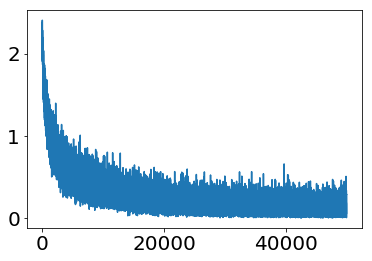

 9824/10000 [============================>.] - ETA: 0sModel evaluation: [0.4918355637550354, 0.87870000000000004]


In [22]:
params = {"activation" : 'relu'}
benchmark_model("hist@relu", **params)

In [16]:
name = "hist@relu"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [19]:
plot_interactive(fc_pred_history)

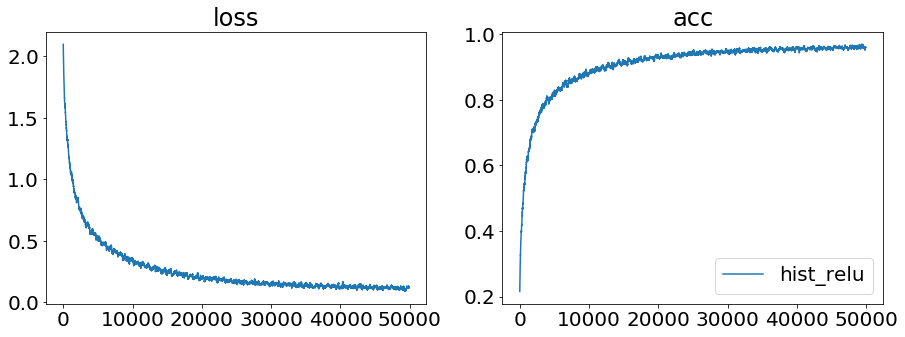

In [25]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

In [26]:
# model = load_model(name)
# model.layers[1].get_weights()[0].std(0)

# Train RELU with BN

100%|██████████| 50000/50000 [43:09<00:00, 19.71it/s]  


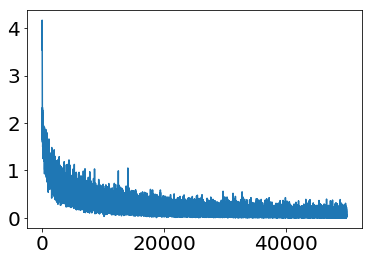

 9760/10000 [============================>.] - ETA: 0sModel evaluation: [0.4658104294359684, 0.89780000000000004]


In [27]:
params = {"activation" : 'relu', "batch_norm": True}
benchmark_model("hist@relu@bn", **params)

In [116]:
name = "hist@relu@bn"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [117]:
plot_interactive(fc_pred_history)

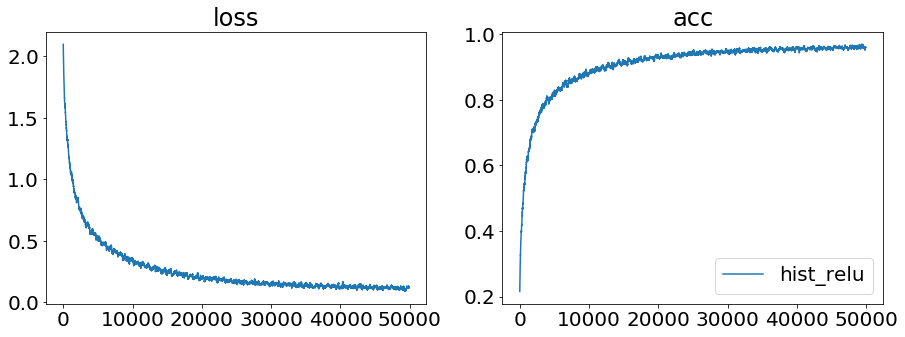

In [30]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Train selu with default initialization

100%|██████████| 50000/50000 [43:52<00:00, 19.41it/s]  


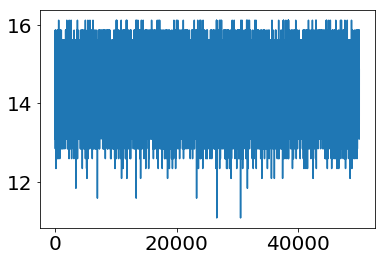

 9760/10000 [============================>.] - ETA: 0sModel evaluation: [14.506285690307617, 0.10000000000000001]


In [31]:
params = {"activation": selu, "selu_init": True}
benchmark_model("hist@selu", **params)

In [119]:
name = "hist@selu"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [120]:
plot_interactive(fc_pred_history)

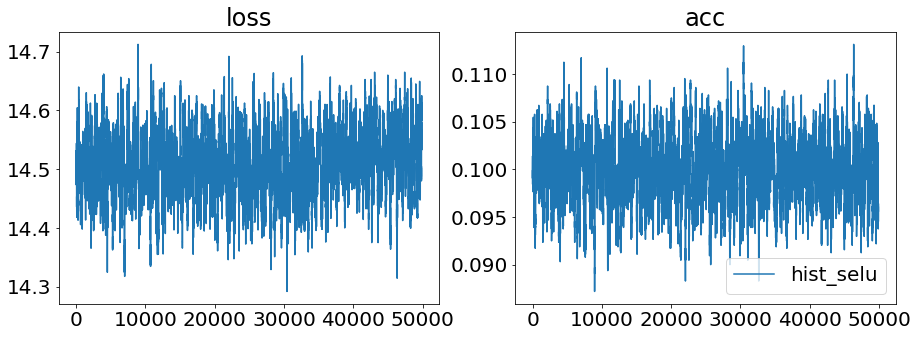

In [ ]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

## Selu with LSUV initialization

In [ ]:
params = {"activation": selu, "lsuv_init": True}
benchmark_model("hist@selu@lsuv_init", **params)

conv2d_17
LSUV initializing conv2d_17
0.224478
1.03894
1.02377
0.977012
0.956699
1.07262
0.978035
1.00935
activation_21
l1
LSUV initializing l1
0.866829
0.981964
1.00189
a1
conv2d_18
LSUV initializing conv2d_18
0.999981
activation_22
l2
LSUV initializing l2
1.01173
1.00509
a2
max_pooling2d_13
conv2d_19
LSUV initializing conv2d_19
0.966281
0.978449
1.02769
0.975031
1.01953
1.01063
0.988104
1.00437
activation_23
l3
LSUV initializing l3
0.994471
a3
max_pooling2d_14
conv2d_20
LSUV initializing conv2d_20
0.83055
1.00102
activation_24
l4
LSUV initializing l4
0.806052


  0%|          | 0/50000 [00:00<?, ?it/s]

1.00404
a4
max_pooling2d_15
flatten_5
dense_5
dense_5 too small
activation_25
LSUV: total layers initialized 8


  3%|▎         | 1691/50000 [01:29<41:48, 19.26it/s]  

In [122]:
name = "hist@selu@lsuv_init"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [123]:
plot_interactive(fc_pred_history)

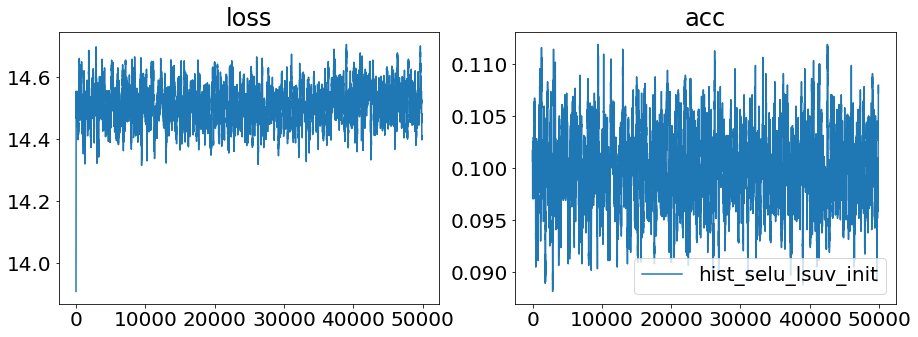

In [124]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Selu with LSUV initialization and SELU init fix

In [ ]:
params = {"activation": selu, "lsuv_init": True, "lsuv_selu_init": True}
benchmark_model("hist@selu@lsuv_selu_init", **params)

In [134]:
name = "hist@selu@lsuv_selu_init"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [135]:
plot_interactive(fc_pred_history)

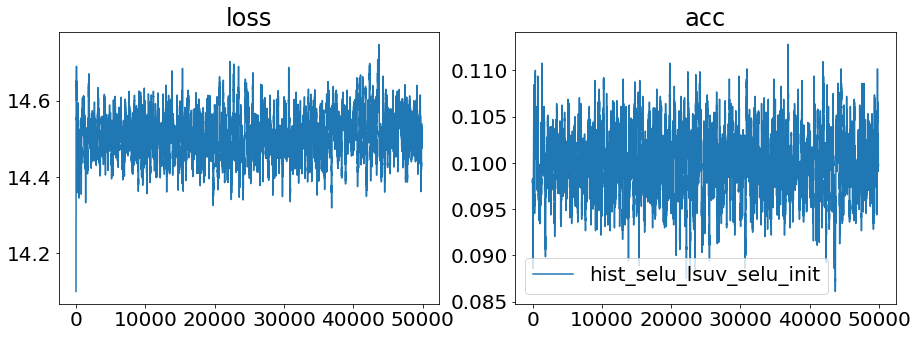

In [128]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing SELU activation with SELU regularization

In [ ]:
params = {"activation": selu, "selu_init": True, "selu_reg": True}
benchmark_model("hist@selu@selu_init@selu_reg", **params)

In [129]:
name = "hist@selu@selu_init@selu_reg"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [130]:
plot_interactive(fc_pred_history)

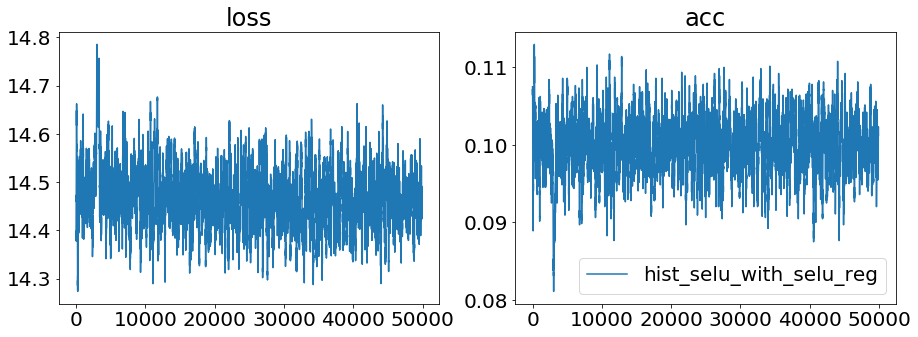

In [131]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

In [ ]:
# load_model(name)

# Testing just ELU activation

In [ ]:
params = {"activation": "elu", "lsuv_init": True, "lsuv_selu_init": True}
benchmark_model("hist@elu@lsuv_selu_init", **params)

In [20]:
name = "hist@elu@lsuv_selu_init"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [21]:
plot_interactive(fc_pred_history)

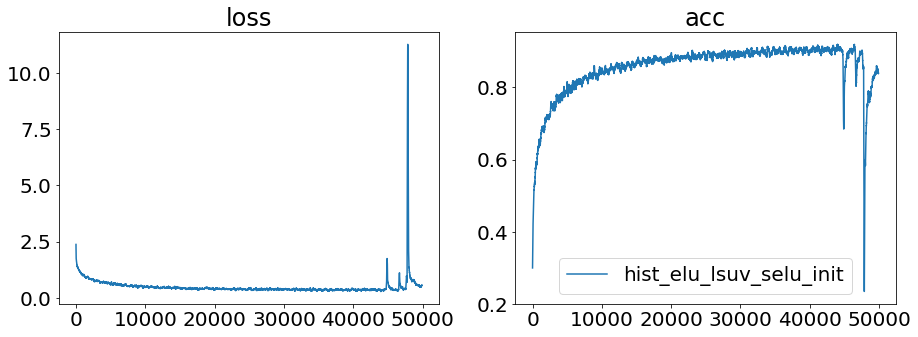

In [139]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing linear model 

100%|██████████| 50000/50000 [36:27<00:00, 22.86it/s] 


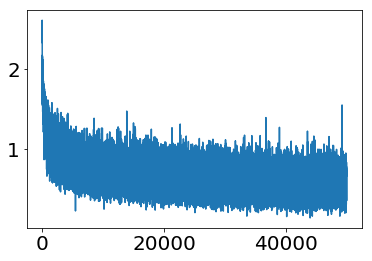

 9888/10000 [============================>.] - ETA: 0sModel evaluation: [0.59906657388210294, 0.81100000000000005]


In [ ]:
params = {"activation": "linear"}
benchmark_model("hist@linear", **params)

In [22]:
name = "hist@linear"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [23]:
plot_interactive(fc_pred_history)

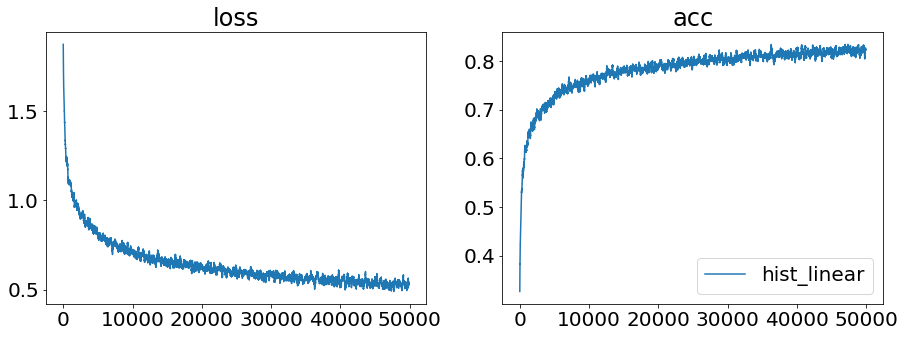

In [ ]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing with prelu

100%|██████████| 50000/50000 [44:25<00:00, 18.76it/s]  


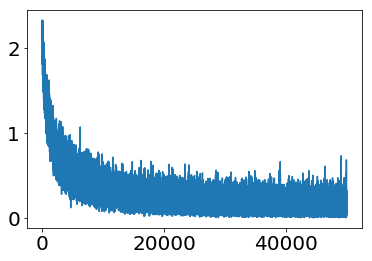

 9760/10000 [============================>.] - ETA: 0sModel evaluation: [0.52258711548447612, 0.88]


In [ ]:
params = {"activation": 'linear', "advanced_activation": prelu}
benchmark_model("hist@prelu", **params)

In [144]:
name = "hist@prelu"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [145]:
plot_interactive(fc_pred_history)

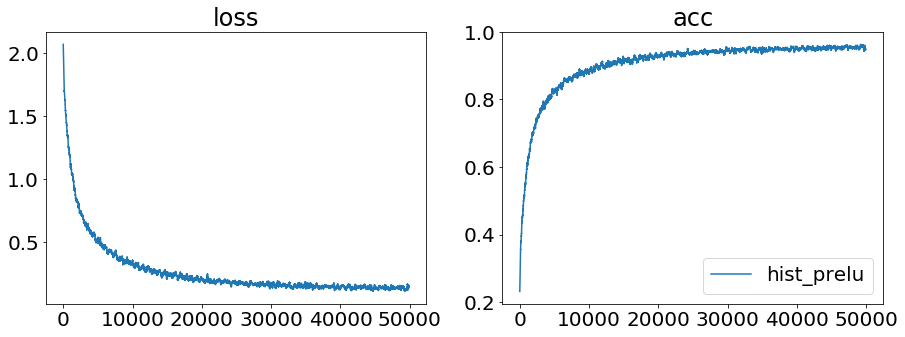

In [ ]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing PRELU with SELU initialization

conv2d_41
LSUV initializing conv2d_41
0.236197
0.978214
0.986258
1.01188
0.962207
0.993288
aux_a1
l1
LSUV initializing l1
0.622635
1.01276
0.998988
a1
conv2d_42
LSUV initializing conv2d_42
0.599789
0.968492
1.04574
0.968454
1.02953
0.983267
0.959846
1.05309
0.968054
1.03008
0.939277
1.01076
aux_a2
l2
LSUV initializing l2
0.560814
0.971899
1.01446
1.0201
1.0061
a2
max_pooling2d_31
conv2d_43
LSUV initializing conv2d_43
0.507085
0.976791
1.0185
0.959452
1.09299
0.919512
1.05916
0.967779
1.01838
1.02649
0.933735
1.04451
aux_a3
l3
LSUV initializing l3
0.438205
0.989012
1.01055
0.997801
a3
max_pooling2d_32
conv2d_44
LSUV initializing conv2d_44
0.501081
1.04064
0.969785
0.961085
0.979835
1.00273
aux_a4
l4
LSUV initializing l4
0.413003
1.02457
1.0151


  0%|          | 0/50000 [00:00<?, ?it/s]

0.99076
a4
max_pooling2d_33
flatten_11
dense_11
dense_11 too small
activation_47
LSUV: total layers initialized 8


100%|██████████| 50000/50000 [47:00<00:00, 17.73it/s]  


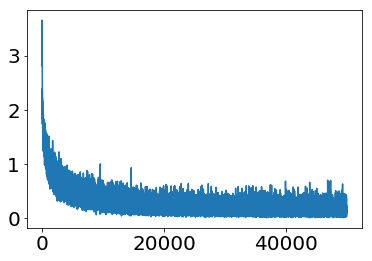

 9760/10000 [============================>.] - ETA: 0sModel evaluation: [0.51207344357967377, 0.87780000000000002]


In [ ]:
params = {"activation": 'linear', "advanced_activation": prelu,
          "lsuv_init": True}
benchmark_model("hist@prelu@lsuv_init", **params)

In [147]:
name = "hist@prelu@lsuv_init"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [148]:
plot_interactive(fc_pred_history)

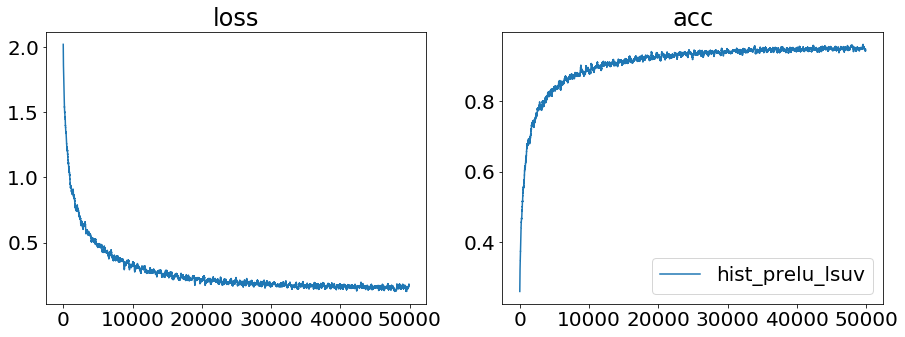

In [ ]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing RELU with LSUV initialization and BN

conv2d_45
LSUV initializing conv2d_45
0.228424
0.99335
activation_48
l1
LSUV initializing l1
0.54748
0.976801
1.01167
1.01446
0.994814
a1
conv2d_46
LSUV initializing conv2d_46
0.844437
1.01234
1.00837
activation_49
l2
LSUV initializing l2
0.374748
1.06396
1.00579
a2
batch_normalization_4
max_pooling2d_34
conv2d_47
LSUV initializing conv2d_47
0.372258
0.956422
1.03622
0.93535
1.02924
1.01734
1.02716
0.981922
0.983743
0.989101
1.00614
activation_50
l3
LSUV initializing l3
0.46996
1.00586
a3
batch_normalization_5
max_pooling2d_35
conv2d_48
LSUV initializing conv2d_48
0.687094
0.992433
activation_51
l4
LSUV initializing l4
0.546115
0.977712
0.985752
1.0561
0.97885
0.96853


  0%|          | 0/50000 [00:00<?, ?it/s]

1.003
a4
batch_normalization_6
max_pooling2d_36
flatten_12
dense_12
dense_12 too small
activation_52
LSUV: total layers initialized 8


100%|██████████| 50000/50000 [46:29<00:00, 17.92it/s]  


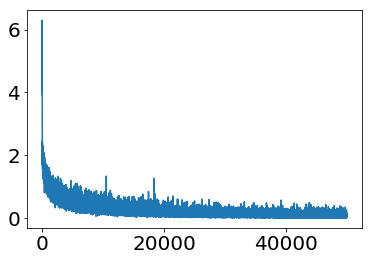

 9920/10000 [============================>.] - ETA: 0sModel evaluation: [0.43319476909935473, 0.9022]


In [ ]:
params = {"activation": 'relu', "batch_norm": True,"lsuv_init": True}
benchmark_model("hist@relu@lsuv_init@bn", **params)

In [150]:
name = "hist@relu@lsuv_init@bn"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)


In [151]:
plot_interactive(fc_pred_history)

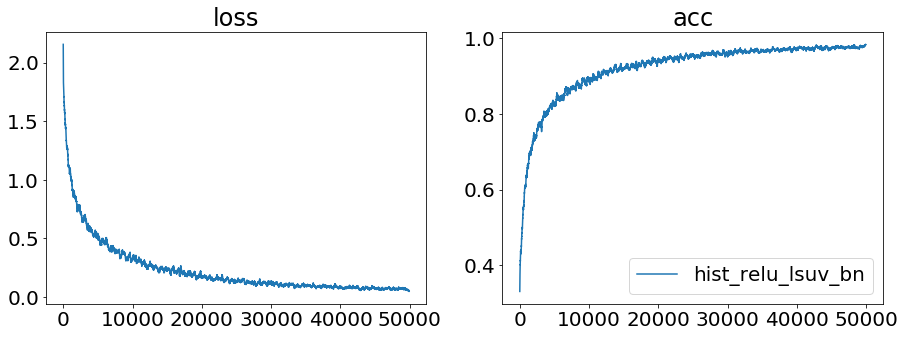

In [ ]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing PRELU with LSUV initialization and BN

conv2d_49
LSUV initializing conv2d_49
0.236351
1.02493
0.968313
1.01076
0.982896
0.981268
0.980797
1.03677
1.00882
aux_a1
l1
LSUV initializing l1
0.55759
1.00309
a1
conv2d_50
LSUV initializing conv2d_50
0.53169
1.01692
1.02279
0.990251
aux_a2
l2
LSUV initializing l2
0.479766
0.990881
a2
batch_normalization_7
max_pooling2d_37
conv2d_51
LSUV initializing conv2d_51
0.653989
0.986126
1.03809
0.922492
1.01366
1.05495
0.926657
1.01947
1.06823
0.942774
1.00807
aux_a3
l3
LSUV initializing l3
0.493658
1.00454
a3
batch_normalization_8
max_pooling2d_38
conv2d_52
LSUV initializing conv2d_52
0.622893
0.985632
1.05028
0.938066
1.07244
0.978245
0.933495
1.0739
0.962641
1.02278
0.955155
1.06317
aux_a4
l4
LSUV initializing l4
0.515983
0.985105


  0%|          | 0/50000 [00:00<?, ?it/s]

1.0071
a4
batch_normalization_9
max_pooling2d_39
flatten_13
dense_13
dense_13 too small
activation_53
LSUV: total layers initialized 8


100%|██████████| 50000/50000 [52:55<00:00, 15.75it/s]  


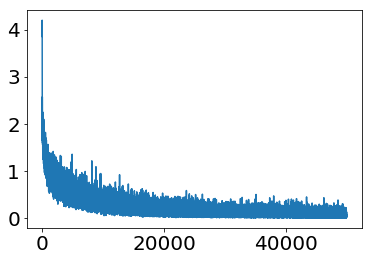

 9888/10000 [============================>.] - ETA: 0sModel evaluation: [0.46044999014139176, 0.89800000000000002]


In [ ]:
params = {"activation": 'linear', "advanced_activation": prelu,
          "lsuv_init": True, "batch_norm": True}
benchmark_model("hist@prelu@lsuv_init@bn", **params)

In [153]:
name = "hist@prelu@lsuv_init@bn"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [154]:
plot_interactive(fc_pred_history)

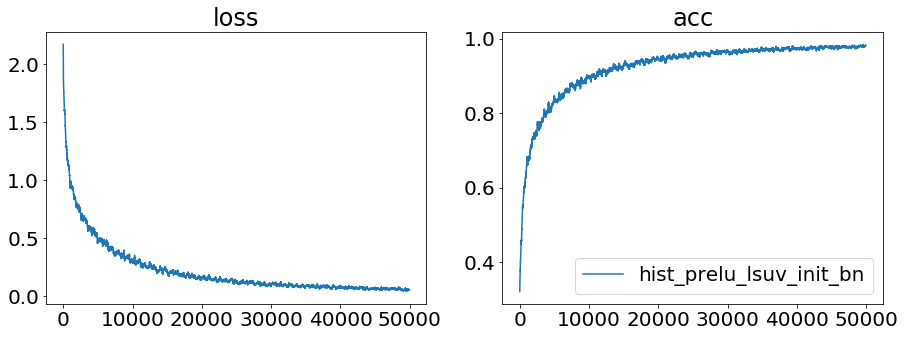

In [155]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing SELU with regularization and BN

with selu Reg
with selu Reg
with selu Reg
with selu Reg
with selu Reg
with selu Reg


  0%|          | 0/50000 [00:00<?, ?it/s]

with selu Reg
with selu Reg


100%|██████████| 50000/50000 [54:28<00:00, 15.08it/s]  


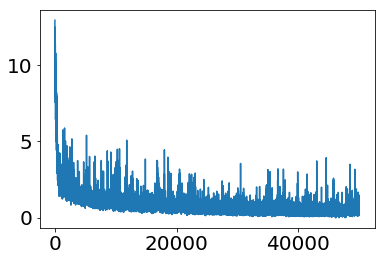

 9920/10000 [============================>.] - ETA: 0sModel evaluation: [0.75102992939949031, 0.81310000000000004]


In [ ]:
params = {"activation": selu, "selu_init": True, "selu_reg": True, "batch_norm": True}
benchmark_model("hist@selu@selu_init@bn@selu_reg", **params)

In [24]:
name = "hist@selu@selu_init@bn@selu_reg"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [25]:
plot_interactive(fc_pred_history)

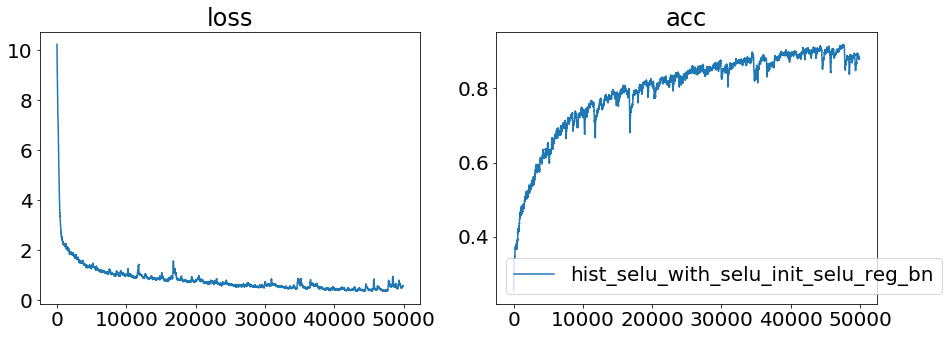

In [ ]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing SELU with BN

100%|██████████| 50000/50000 [50:25<00:00, 16.76it/s]  


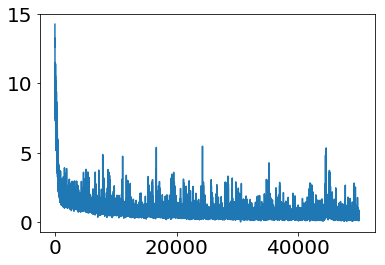

 9888/10000 [============================>.] - ETA: 0sModel evaluation: [0.46611917419433596, 0.86260000000000003]


In [ ]:
params = {"activation": selu, "selu_init": True, "batch_norm": True}
benchmark_model("hist@selu@selu_init@bn", **params)

In [26]:
name = "hist@selu@selu_init@bn"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [27]:
plot_interactive(fc_pred_history)

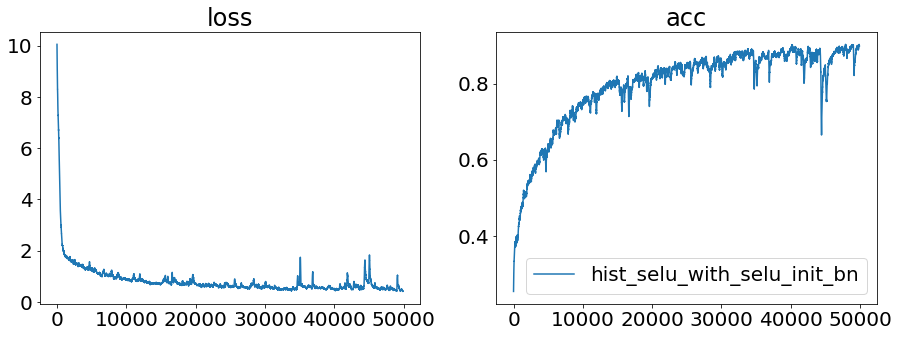

In [ ]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing PRELU with BN and SELU regularization

with selu Reg
with selu Reg
with selu Reg
with selu Reg
with selu Reg
with selu Reg
with selu Reg
with selu Reg
conv2d_61
LSUV initializing conv2d_61
0.242575
0.943937
0.993336
aux_a1
l1
LSUV initializing l1
0.657648
0.944656
1.08686
0.971735
0.970257
0.997895
a1
conv2d_62
LSUV initializing conv2d_62
0.455343
0.977609
0.997132
aux_a2
l2
LSUV initializing l2
0.512385
0.992645
a2
batch_normalization_16
max_pooling2d_46
conv2d_63
LSUV initializing conv2d_63
0.537224
0.998039
aux_a3
l3
LSUV initializing l3
0.386591
1.00851
a3
batch_normalization_17
max_pooling2d_47
conv2d_64
LSUV initializing conv2d_64
0.666457
0.989456
1.00718
aux_a4
l4
LSUV initializing l4
0.466446
0.964703
1.02552
0.988051
1.03754
0.948518
1.02568


  0%|          | 0/50000 [00:00<?, ?it/s]

0.998143
a4
batch_normalization_18
max_pooling2d_48
flatten_16
dense_16
dense_16 too small
activation_64
LSUV: total layers initialized 8


100%|██████████| 50000/50000 [52:19<00:00, 15.93it/s]  


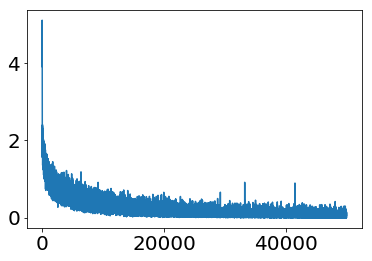

 9824/10000 [============================>.] - ETA: 0sModel evaluation: [0.39756453564465044, 0.90849999999999997]


In [ ]:
params = {"activation": 'linear', "advanced_activation": prelu,
          "lsuv_init": True, "batch_norm": True, "selu_reg": True}
benchmark_model("hist@prelu@lsuv_init@bn@selu_reg", **params)

In [28]:
name = "hist@prelu@lsuv_init@bn@selu_reg"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [29]:
plot_interactive(fc_pred_history)

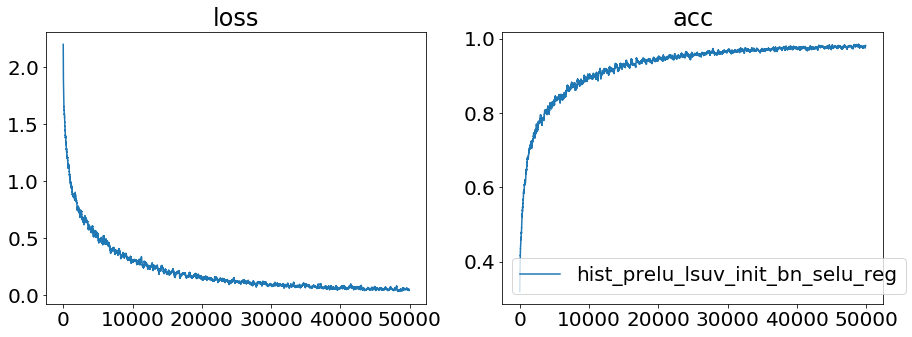

In [ ]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing PRELU with BN and SELU regularization with LetsConv

with LetsConv2D
with selu Reg
with selu Reg
with selu Reg
with selu Reg
with selu Reg


  0%|          | 0/50000 [00:00<?, ?it/s]

with selu Reg
with selu Reg
with selu Reg
lets_conv2d_2
aux_a1
l1
a1
lets_conv2d_3
aux_a2
l2
a2
batch_normalization_1
max_pooling2d_1
lets_conv2d_4
aux_a3
l3
a3
batch_normalization_2
max_pooling2d_2
lets_conv2d_5
aux_a4
l4
a4
batch_normalization_3
max_pooling2d_3
flatten_1
dense_1
dense_1 too small
activation_1
LSUV: total layers initialized 0


100%|██████████| 50000/50000 [51:43<00:00, 16.64it/s]  


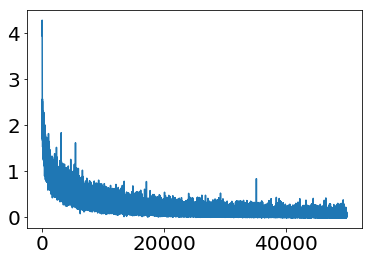

 9920/10000 [============================>.] - ETA: 0sModel evaluation: [0.40636211217567325, 0.90880000000000005]


In [15]:
params = {"activation": 'linear', "advanced_activation": prelu,
          "lsuv_init": True, "batch_norm": True, "selu_reg": True, "lets_conv": True}
benchmark_model("hist@prelu@lsuv_init@bn@selu_reg@lets_conv", **params)

In [30]:
name = "hist@prelu@lsuv_init@bn@selu_reg@lets_conv"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [31]:
plot_interactive(fc_pred_history)

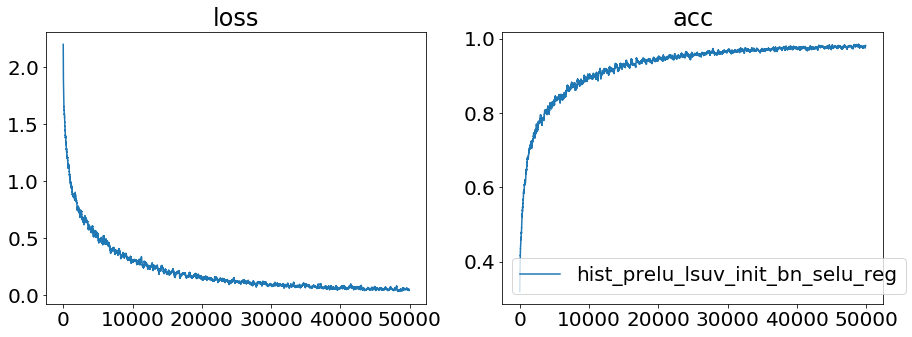

In [20]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Testing PRELU with BN and Ortho regularization

with ortho Reg
with ortho Reg
with ortho Reg
with ortho Reg
with ortho Reg
with ortho Reg
with ortho Reg
with ortho Reg
conv2d_65
LSUV initializing conv2d_65
0.225975
1.03549
0.955787
0.996179
aux_a1
l1
LSUV initializing l1
0.59566
0.970835
0.987906
1.00441
a1
conv2d_66
LSUV initializing conv2d_66
0.430898
0.951779
1.01075
0.975611
1.06307
0.939255
1.00084
aux_a2
l2
LSUV initializing l2
0.342041
1.02723
1.05124
0.936314
0.951377
1.08391
0.914595
1.12023
0.94756
0.980459
1.0669
0.992868
a2
batch_normalization_19
max_pooling2d_49
conv2d_67
LSUV initializing conv2d_67
0.509115
1.0411
0.977699
1.00614
aux_a3
l3
LSUV initializing l3
0.442094
1.0213
1.01287
1.0155
0.958092
1.01672
1.00385
a3
batch_normalization_20
max_pooling2d_50
conv2d_68
LSUV initializing conv2d_68
0.504999
0.990601
aux_a4
l4
LSUV initializing l4
0.407926
1.04123
0.976096


  0%|          | 0/50000 [00:00<?, ?it/s]

1.00469
a4
batch_normalization_21
max_pooling2d_51
flatten_17
dense_17
dense_17 too small
activation_65
LSUV: total layers initialized 8


100%|██████████| 50000/50000 [51:33<00:00, 16.16it/s]  


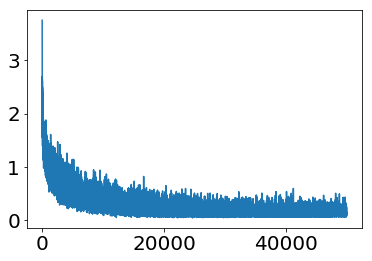

 9824/10000 [============================>.] - ETA: 0sModel evaluation: [0.46275143313407896, 0.90410000000000001]


In [ ]:
params = {"activation": 'linear', "advanced_activation": prelu,
          "lsuv_init": True, "batch_norm": True, "ortho_reg": True}
benchmark_model("hist@prelu@lsuv_init@bn@ortho_reg", **params)

In [32]:
name = "hist@prelu@lsuv_init@bn@ortho_reg"
fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)

In [33]:
plot_interactive(fc_pred_history)

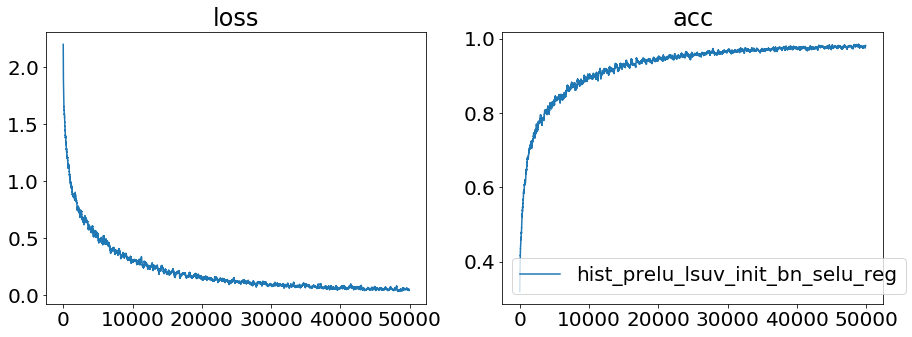

In [ ]:
loss_history_tuple = (params, loss_history)
plot_loss_history(loss_history_tuple)

# Plot summary

In [21]:
from glob import glob
import os

In [22]:
prefix = "cifar10_conv"
history_files = glob(f"activations_history_data/{prefix}*.pkl")
history_files = list(filter(lambda x: "@" in x, history_files))
history_files

['activations_history_data/cifar10_conv_hist@selu@selu_init@selu_reg.pkl',
 'activations_history_data/cifar10_conv_hist@selu@lsuv_selu_init.pkl',
 'activations_history_data/cifar10_conv_hist@prelu.pkl',
 'activations_history_data/cifar10_conv_hist@relu@bn.pkl',
 'activations_history_data/cifar10_conv_hist@selu@selu_init@bn@selu_reg.pkl',
 'activations_history_data/cifar10_conv_hist@selu@lsuv_init.pkl',
 'activations_history_data/cifar10_conv_hist@elu@lsuv_selu_init.pkl',
 'activations_history_data/cifar10_conv_hist@prelu@lsuv_init.pkl',
 'activations_history_data/cifar10_conv_hist@selu@selu_init@bn.pkl',
 'activations_history_data/cifar10_conv_hist@relu.pkl',
 'activations_history_data/cifar10_conv_hist@selu.pkl',
 'activations_history_data/cifar10_conv_hist@prelu@lsuv_init@bn.pkl',
 'activations_history_data/cifar10_conv_hist@prelu@lsuv_init@bn@selu_reg@lets_conv.pkl',
 'activations_history_data/cifar10_conv_hist@linear.pkl',
 'activations_history_data/cifar10_conv_hist@prelu@lsuv_ini

In [23]:
features = []
for f in history_files:
    features += f.split(".pkl")[0].split("@")[1:]

features_list = list(set(features))
features_list

['linear',
 'bn',
 'lsuv_init',
 'selu',
 'elu',
 'lets_conv',
 'ortho_reg',
 'prelu',
 'selu_reg',
 'lsuv_selu_init',
 'selu_init',
 'relu']

In [24]:
import pandas as pd

df = pd.DataFrame(columns=["name", "test_acc", "train_acc", "test_loss", "train_loss"])

loss_history_tuple_list = []
for i, hist_file in tqdm(enumerate(history_files)):
    name = os.path.split(hist_file)[-1][len(prefix)+1:-4]
    fc_pred_history, loss_history, test_evaluation, params = get_history_data(name)    
    loss_history_tuple_list.append((params, loss_history))
    
    # table
    mean_acc = np.array(loss_history)[-50:, 1].mean()
    mean_loss = np.array(loss_history)[-50:, 0].mean()
    
    row = [name, 
           f"{test_evaluation[1]:5.3f}", 
           f"{mean_acc:5.3f}", 
           f"{test_evaluation[0]:5.3f}", 
           f"{mean_loss:5.3f}"]
    df.loc[i] = row

17it [00:02,  7.00it/s]


In [25]:
new_df = df.copy()

for feat in features_list:
    new_df[feat] = new_df.name.apply(lambda x: "X" if feat in x.split("@") else "-")
new_df = new_df.drop("name", axis=1)

new_df.sort_values(by="test_acc", ascending=False)

,test_acc,train_acc,test_loss,train_loss,linear,bn,lsuv_init,selu,elu,lets_conv,ortho_reg,prelu,selu_reg,lsuv_selu_init,selu_init,relu
12,0.909,0.980,0.406,0.046,-,X,X,-,-,X,-,X,X,-,-,-
15,0.908,0.980,0.398,0.041,-,X,X,-,-,-,-,X,X,-,-,-
14,0.904,0.975,0.463,0.128,-,X,X,-,-,-,X,X,-,-,-,-
16,0.902,0.980,0.433,0.056,-,X,X,-,-,-,-,-,-,-,-,X
3,0.898,0.975,0.466,0.076,-,X,-,-,-,-,-,-,-,-,-,X
11,0.898,0.985,0.460,0.047,-,X,X,-,-,-,-,X,-,-,-,-
2,0.880,0.954,0.523,0.143,-,-,-,-,-,-,-,X,-,-,-,-
9,0.879,0.963,0.492,0.119,-,-,-,-,-,-,-,-,-,-,-,X
7,0.878,0.950,0.512,0.157,-,-,X,-,-,-,-,X,-,-,-,-
8,0.863,0.900,0.466,0.401,-,X,-,X,-,-,-,-,-,-,X,-


In [172]:
def plot_loss_history_raport(loss_history_tuple, start_step=0, fontsize=8, min_acc=0.0, max_acc=1):
    
    def running_mean(x, N=100):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / N 
    
    plt.figure(figsize=(20, 15))
    plt.subplot(211)
    plt.title("loss")
    for i in range(len(loss_history_tuple)):
        params, loss_history = loss_history_tuple[i]        
        mean_acc = np.array(loss_history)[-20:, 1].mean()
        if mean_acc > min_acc and mean_acc < max_acc:
            print(params['name'], mean_acc)
            plt.plot(running_mean(np.array(loss_history)[start_step:, 0]), label=params['name'])
    
    plt.ylim([0., 1.6])
    plt.legend(fontsize=fontsize, loc=2)
    plt.subplot(212)
    plt.title("acc")
    for i in range(len(loss_history_tuple)):
        params, loss_history = loss_history_tuple[i]    
        mean_acc = np.array(loss_history)[-20:, 1].mean()
        if mean_acc > min_acc and mean_acc < max_acc:
            plt.plot(running_mean(np.array(loss_history)[start_step:, 1]), label=params['name'])
    
    plt.legend(fontsize=fontsize, loc=2)
    plt.show()  

hist_selu_with_selu_reg 0.109375
hist_selu_lsuv_selu_init 0.0875
hist_prelu 0.942187
hist_relu_bn 0.970312
hist_selu_with_selu_init_selu_reg_bn 0.884375
hist_selu_lsuv_init 0.117188
hist_elu_lsuv_selu_init 0.85
hist_prelu_lsuv 0.957812
hist_selu_with_selu_init_bn 0.902344
hist_relu 0.960938
hist_selu 0.104687
hist_prelu_lsuv_init_bn 0.9875
hist_linear 0.804688
hist_prelu_lsuv_init_bn_ortho_reg 0.976562
hist_prelu_lsuv_init_bn_selu_reg 0.977344
hist_relu_lsuv_bn 0.980469


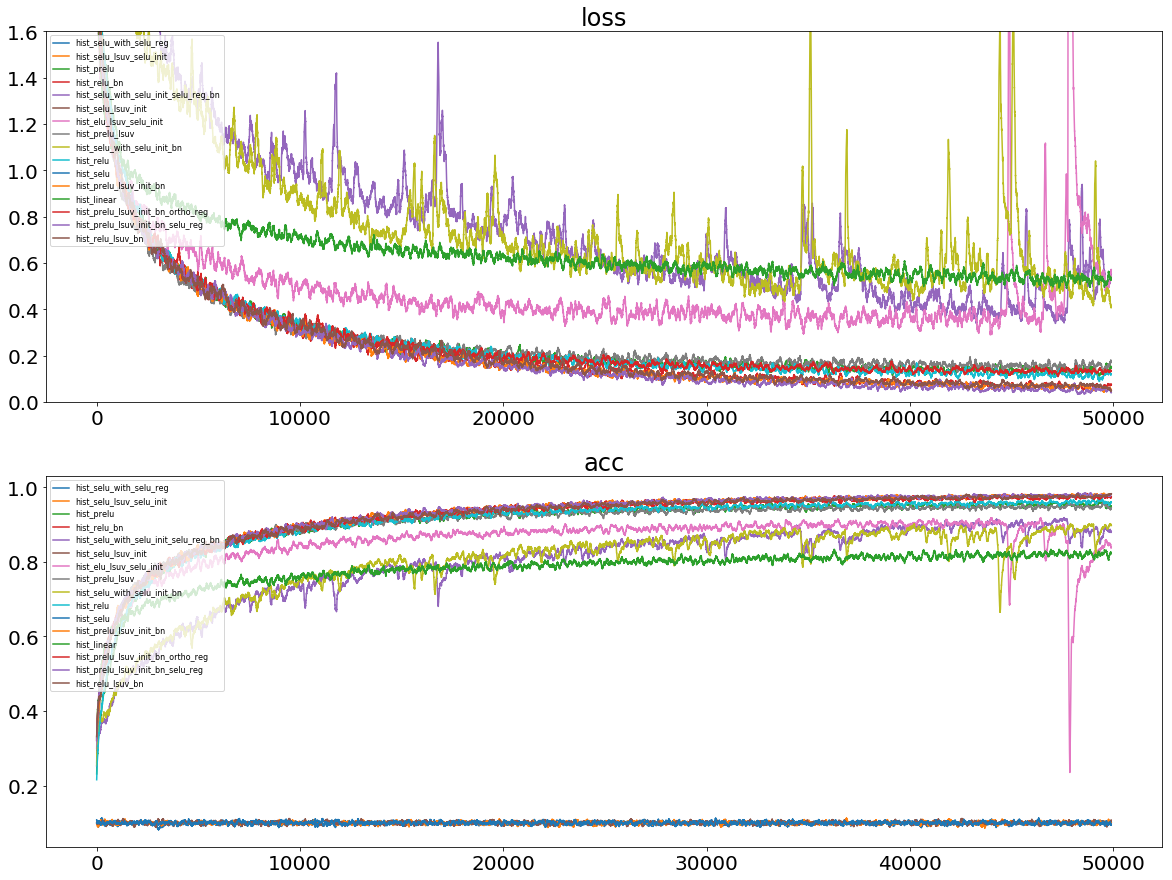

In [173]:
plot_loss_history_raport(loss_history_tuple_list)

hist_selu_with_selu_reg 0.109375
hist_selu_lsuv_selu_init 0.0875
hist_prelu 0.942187
hist_relu_bn 0.970312
hist_selu_with_selu_init_selu_reg_bn 0.884375
hist_selu_lsuv_init 0.117188
hist_elu_lsuv_selu_init 0.85
hist_prelu_lsuv 0.957812
hist_selu_with_selu_init_bn 0.902344
hist_relu 0.960938
hist_selu 0.104687
hist_prelu_lsuv_init_bn 0.9875
hist_linear 0.804688
hist_prelu_lsuv_init_bn_ortho_reg 0.976562
hist_prelu_lsuv_init_bn_selu_reg 0.977344
hist_relu_lsuv_bn 0.980469


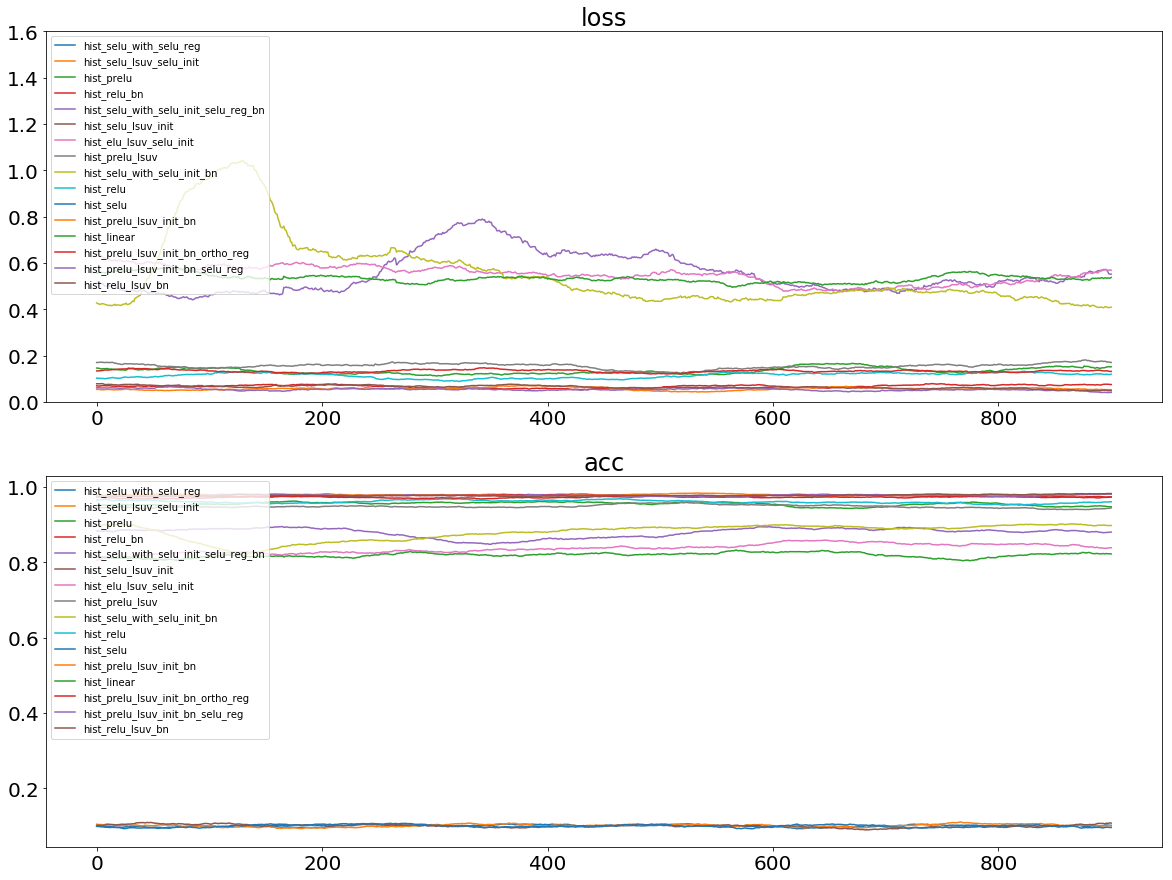

In [174]:
plot_loss_history_raport(loss_history_tuple_list, start_step=-1000, fontsize=10)

hist_prelu_lsuv 0.957812
hist_selu_with_selu_init_bn 0.902344
hist_prelu_lsuv_init_bn 0.9875
hist_relu_bn 0.970312
hist_prelu_lsuv_init_bn_ortho_reg 0.976562
hist_prelu_lsuv_init_bn_selu_reg 0.977344
hist_prelu 0.942187
hist_elu_lsuv_selu_init 0.85
hist_relu_lsuv_bn 0.980469
hist_selu_with_selu_init_selu_reg_bn 0.884375
hist_relu 0.960938


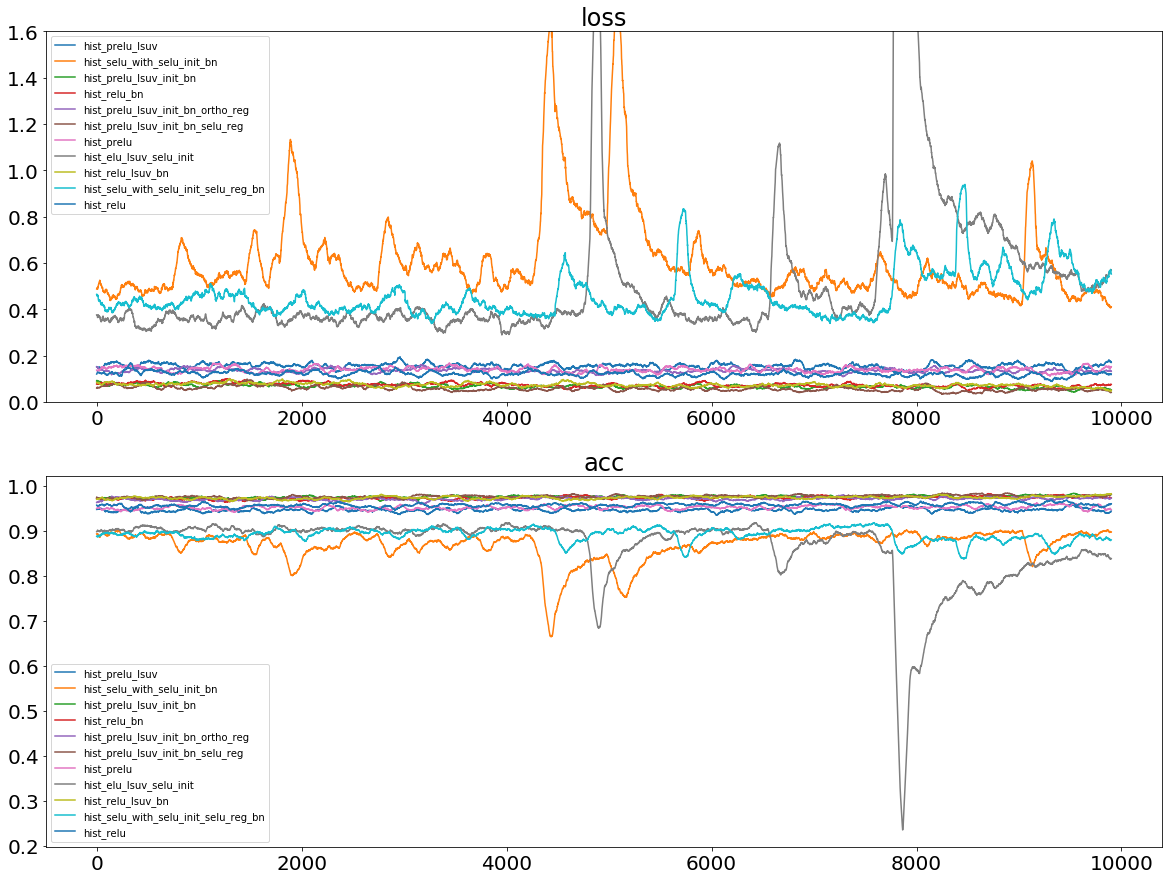

In [101]:
plot_loss_history_raport(loss_history_tuple_list, start_step=-10000, fontsize=10, min_acc=0.8)

hist_selu_with_selu_reg 0.109375
hist_selu_lsuv_selu_init 0.0875
hist_selu_lsuv_init 0.117188
hist_selu 0.104687


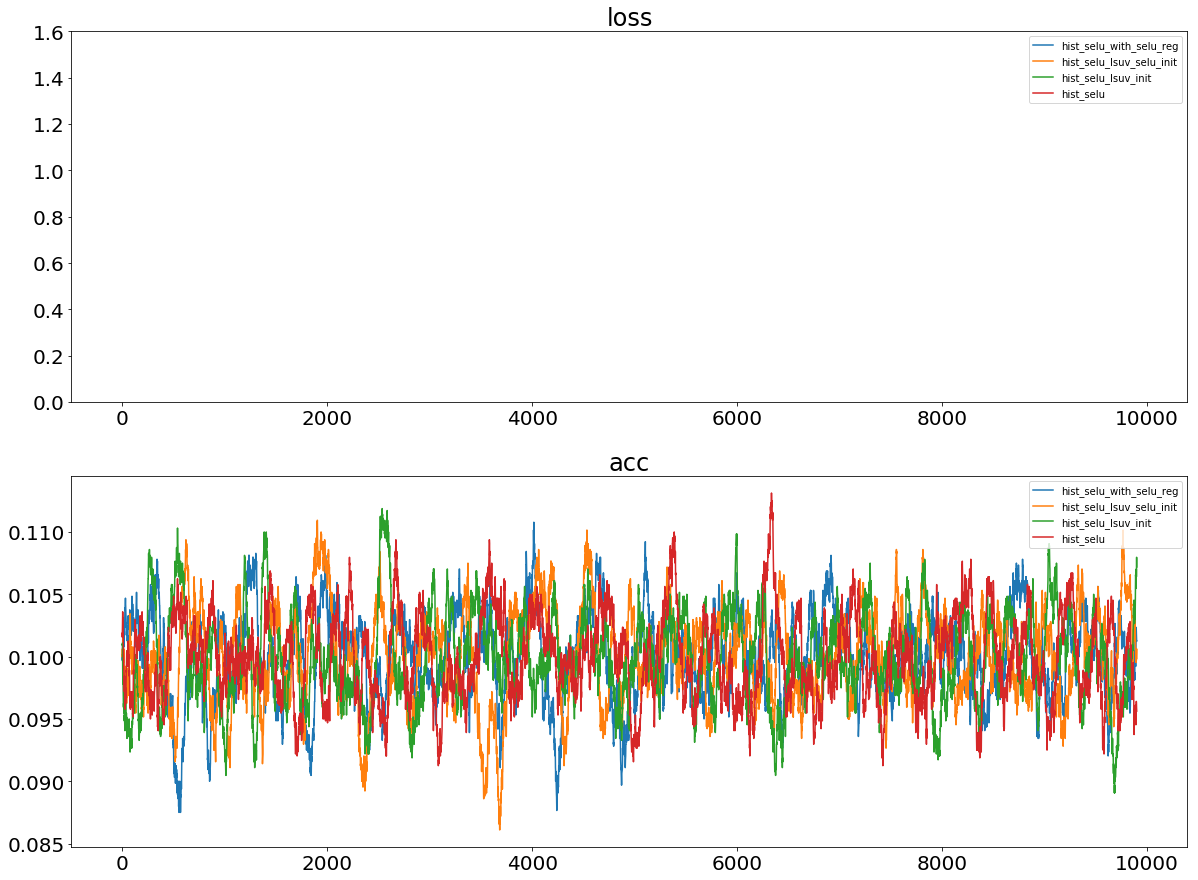

In [102]:
plot_loss_history_raport(loss_history_tuple_list, start_step=-10000, fontsize=10, max_acc=0.2)